# 분류

In [1]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
matplotlib.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴드
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## 3.1 MNIST 데이터
- 미국 인구조사국 직원들이 손으로 쓴 70,000개의 작은 숫자 이미지를 모은 데이터

In [2]:
# MNIST 내려받기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array(['5', '0', '4', ..., '4', '5', '6'], dtype=object),
 'frame': None,
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46',
  'pixel47',
  'pixel48',
  'pixel49',
  'pixel50',


In [3]:
X,y = mnist['data'],mnist['target']
y = y.astype(np.int)
X.shape, y.shape # 70,000만 개의 데이터와 784개의 특성(픽셀 28 * 28)

((70000, 784), (70000,))

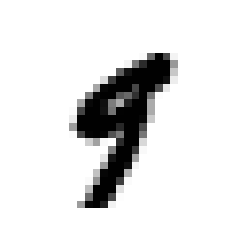

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000] # 임의로 하나 추출
some_digit_image = some_digit.reshape(28,28) # 28*28로 변환
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest') # cmap ==> 그림 종류
plt.axis('off') # 축 없음
plt.show()

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


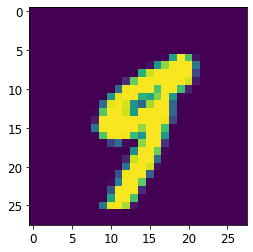

In [5]:
plt.imshow(some_digit_image);

In [6]:
y[36000] # 실제로도 9

9

In [7]:
# 숫자 그림을 그리는 함수
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")
    
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row) # 만약 10개 이하면 해당 instances 길이가 행 길이가 됨
    images = [instance.reshape(size,size) for instance in instances] # 모든 이미지 28*28로 바꾼 값 images에 저장
    n_rows = (len(instances) - 1) // images_per_row + 1 # 전체 이미지 행 수 결정
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row] # 행 하나씩 rimages에 저장
        row_images.append(np.concatenate(rimages, axis=1)) # 행 하나씩 열단위로 병합(1행1열 ~ 1행10열 병합)
    image = np.concatenate(row_images, axis=0) # 병합된 행 행단위로 병합(1행 ~ 10행 병합)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

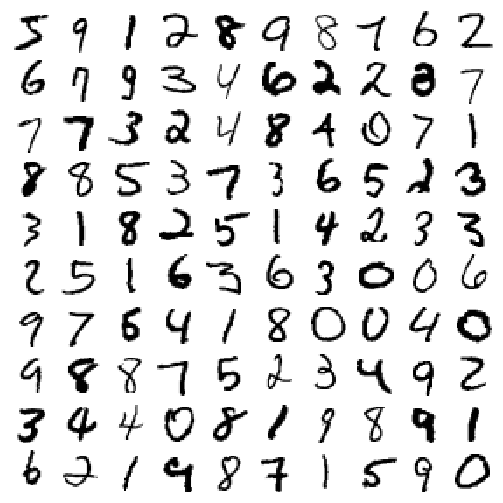

In [8]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] # 60000 : 10000으로 분리

In [10]:
shuffle_index = np.random.permutation(60000) # permutation ==> 순서를 임의로 바꾸거나 임의의 순열 반환
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index] # 연속된 샘플이 연이어 나타나면 성능 하락하므로 순서 섞기

## 3.2 이진 분류기 훈련
- 5, other 5의 이진분류를 실시
- 확률적 경사 하강법(SDG): 매우 큰 데이터셋 효율적으로 처리(온라인 학습에 유리) -> 한 번에 하나의 훈련 샘플을 독립적으로 처리하기 때문

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
np.unique(y_train_5, return_counts=True)

(array([False,  True]), array([54579,  5421], dtype=int64))

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [14]:
sgd_clf.predict([some_digit]) # 9이므로 False로 맞춤

array([False])

## 3.3 성능 측정

#### 3.3.1 교차 검증을 사용한 정확도 측정

In [15]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.964 , 0.9579, 0.9571])

In [16]:
# 교차검증 구현
from sklearn.model_selection import StratifiedKFold # StratifiedKFold ==> 계층적 샘플링
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred), end = ' ') # 괜찮은 성능이 나옴

C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.964 

C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.9579 0.9571 

C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [17]:
# 모든 이미지를 False(5 other)로 분류하는 더미 분류기
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy") # 무조건 5가 아니라고 해도 불균형 데이터라 높은 성능을 보임

array([0.909  , 0.90745, 0.9125 ])

##### 결과
- 모두 5가 아니라고 예측하더라도 성능이 90%이상 나오므로 이는 불균형 데이터
- 이 결과는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여줌(특히, 불균형 데이터를 다룰 때)

#### 3.3.2 오차 행렬

In [18]:
from sklearn.model_selection import cross_val_predict # cross_val_score 함수처럼 교차검증을 시행하나 점수 대신 예측을 반환

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [19]:
# 이진 분류의 confusion_matrix 생성
from sklearn.metrics import confusion_matrix # confusion_matrix ==> 혼동행렬 생성

confusion_matrix(y_train_5, y_train_pred) # 행 = 실제 클래스 // 열 = 예측 클래스

array([[54058,   521],
       [ 1899,  3522]], dtype=int64)

In [20]:
y_train_perfect_predictions = y_train_5

In [21]:
# 완벽한 분류기 예시
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

#### 3.3.3 정밀도(precision)과 재현율(recall)

In [22]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred) # 정밀도와 재현율

(0.8711352955725946, 0.6496956281128943)

In [23]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred) # f1 스코어 = 정밀도와 재현율의 조화 평균

0.7442941673710904

#### 3.3.4 정밀도/재현율 트레이드오프

In [24]:
y_scores = sgd_clf.decision_function([some_digit]) # decision_function ==> 샘플의 점수 반환
y_scores

array([-400042.39513131])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores > threshold) # 임곗값보다 커야 True(양성)
y_some_digit_pred # SGD 임계값과 같이 0으로 설정시 False로 판단

array([False])

In [26]:
threshold = -300000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred # 임곗값을 낮췄으므로 False -> True가 됨

array([False])

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function") # decision_function ==> SGD의 분류 기준
# method를 decision_function로 설정하여 각 데이터별 결정 함수 값을 반환받게 함

C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [28]:
y_scores.shape

(60000,)

In [29]:
y_scores[:3]

array([-545086.1906455 , -200238.20632717, -366873.76172794])

In [30]:
from sklearn.metrics import precision_recall_curve # precision_recall_curve ==> 정밀도, 재현율, 임계값 반환

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


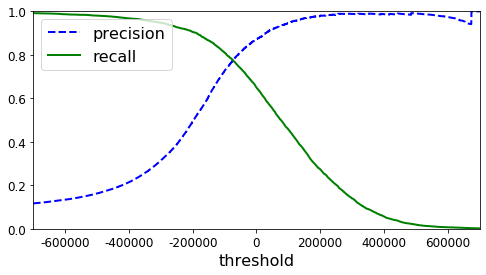

In [31]:
# 임계값에 따른 정밀도, 재현율 그래프 그리는 함수
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="recall", linewidth=2)
    plt.xlabel("threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

In [32]:
(y_train_pred == (y_scores > 0)).all() # SGD 임계값이 0이므로 모두 True

True

In [33]:
y_train_pred_90 = (y_scores > 70000) # 70000보다 큰지 작은지 여부
precision_score(y_train_5, y_train_pred_90) # 임계값을 70000으로 했을 때 예측값(임계값을 높였으므로 높아짐)

0.9309882747068676

In [34]:
recall_score(y_train_5, y_train_pred_90) # 재현율 점수(임계값을 높였으므로 떨어짐)

0.5126360450101457

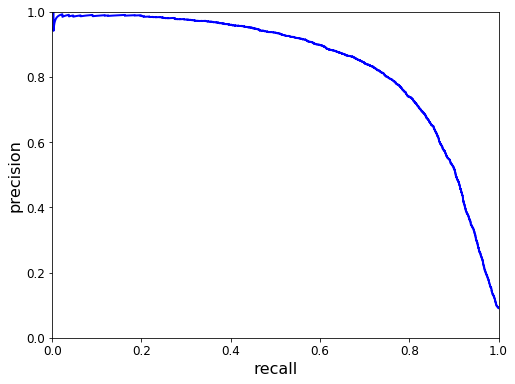

In [35]:
# 재현율에 따른 정밀도 그래프 그리는 함수
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("recall", fontsize=16)
    plt.ylabel("precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

### 3.3.5 ROC 곡선(수신기 조작 곡선)
- 이진 분류에서 주로 사용하며 TPF(진짜 양성 비율: 재현율)에 대한 FPR(거짓 양성 비율: 1-특이도)의 그래프
- 곡산 하 면적(AUC)는 ROC 곡선 아래의 면적으로 완전 랜덤이 0.5이고 완벽한 분류기는 1을 가짐

In [36]:
from sklearn.metrics import roc_curve # roc_curve ==> FPR, TPR, 임계값 반환하는 함수

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores) # 정밀도, 재현율가 똑같이 결정 함수값이 들어가야함

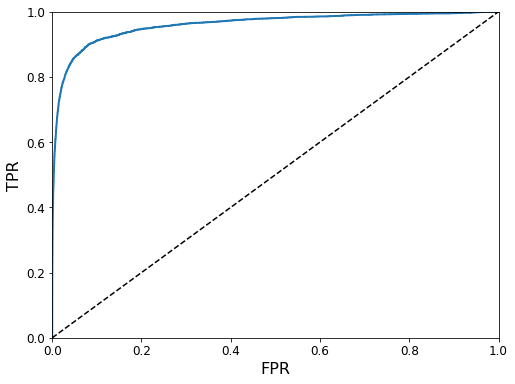

In [37]:
# ROC 곡선 그리는 함수
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 랜덤 분류기의 ROC 곡선
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR', fontsize=16)
    plt.ylabel('TPR', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr) # SGD의 ROC 곡선
plt.show()

In [38]:
from sklearn.metrics import roc_auc_score # roc_auc_score ==> AUC 반환하는 함수

roc_auc_score(y_train_5, y_scores) # 곡선하 면적(완벽한 모델=1 // 완전한 랜덤 모델=0.5)

0.9598058535696421

In [39]:
# 랜덤 포레스트의 ROC, AUC(랜덤 포레스트는 decision_function() 매서드가 없음 대신 predict_proba() 매서드를 가지고 있음)
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba") # predict_proba ==> 분류 확률

In [40]:
y_scores_forest = y_probas_forest[:, 1] # 점수는 양상 클래스의 확률입니다
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest) # FPR, TPR, 임계값 얻기

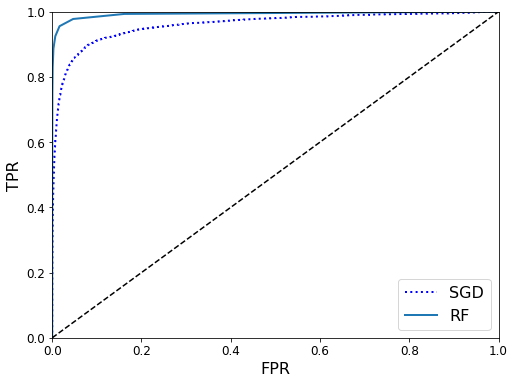

In [41]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD") # SGD의 ROC 곡선(다른 곡선으로 표시하려고 plot 사용한 듯)
plot_roc_curve(fpr_forest, tpr_forest, "RF") # RF의 ROC 곡선
plt.legend(loc="lower right", fontsize=16)
plt.show() # 랜덤 포레스트가 더 좋은 성능을 보여줌

In [42]:
roc_auc_score(y_train_5, y_scores_forest) # RF의 AUC

0.9928250745111685

In [43]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3) # 기존 cross_val_predict는 확률(proba) 추출한 것
precision_score(y_train_5, y_train_pred_forest), recall_score(y_train_5, y_train_pred_forest) # 정밀도, 재현율

(0.9870386643233744, 0.8288138719793396)

## 3.4 다중 분류
- 랜덤 포레스트, 나이브 베이즈 등은 다중 분류 가능하나 SVM, 선형분류기 등은 이진 분류만 가능(다만, 모델 여러개 만들면 가능)
- OvA(One-versus-All): 일대다 전략이라고 하며 n개의 분류에 대해 n개의 분류기 생성(하나의 이미지 분류시 가장 높은 결정 점수 선택)
- OvO(One-versus-One): 일대일 전략이라고 하며 n개의 분류에 대해 n(n-1)/2개의 분류기 생성(하나의 이미지 분류시 가장 많은 클래스가 나온 것을 선택)
- SVM과 같은 일부 알고리즘의 경우 OvO(SVM은 데이터 크기에 민감하므로) 선호하나 다른 대부분 알고리즘은 OvA 선호

In [44]:
sgd_clf.fit(X_train, y_train) # y_train_5가 아닌 y_train
sgd_clf.predict([some_digit])

C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([9])

In [45]:
some_digit_scores = sgd_clf.decision_function([some_digit]) # SGD의 결정함수 반환
some_digit_scores # SGD의 경우 다중 분류에서 10개의 분류기중 가장 높은 값으로 반환한 것(4)

array([[-780634.17445014, -367988.10902669, -857510.2219226 ,
        -109587.17435534,   -6978.239532  , -120352.38122307,
        -785831.32198027, -377771.38059503, -198143.6559996 ,
         107815.22648992]])

In [46]:
np.argmax(some_digit_scores) # argmax ==> 가장 큰 값 반환 // argmin ==> 가장 작은 값 반환

9

In [47]:
sgd_clf.classes_, sgd_clf.classes_[5] # classes_ ==> 클래스의 인덱스 값 저장, 해당 인덱스값 불러올 경우 실제 class명 반환됨

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 5)

In [48]:
# 모델을 OvO를 사용하도록 강제 -> OneVsOneClassifier // 모델을 OvA를 사용하도록 강제 -> OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42)) # SGD의 OvO
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn

C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn

array([4])

In [49]:
len(ovo_clf.estimators_) # 45개의 분류기 생성됨

45

In [50]:
# 랜덤 포레스트로 예측(원래 다중 예측 가능하므로 OvO, OvA 적용할 필요 없음)
forest_clf.fit(X_train, y_train) # 랜덤 포레스트 훈련
forest_clf.predict([some_digit])

array([9])

In [51]:
forest_clf.predict_proba([some_digit]) # 클래스 분류 확률

array([[0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0.9]])

In [52]:
# SGD의 다중분류 성능 측정
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.83935, 0.85125, 0.8676 ])

In [53]:
# 간단한 표준화를 통한 성능 향상(85~86 --> 90~91)
from sklearn.preprocessing import StandardScaler # StandardScaler ==> 표준화 함수

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64)) # np.float64 타입으로 표준화
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.91155, 0.91005, 0.9095 ])

## 3.5 에러 분석
- 가능성이 높은 모델 하나를 찾았다고 가정할 때, 이 모델의 성능을 향상시킬 방법을 찾는 방법 중 하나는 에러의 종류를 분석하는 것

In [54]:
# 다중 분류의 confusion_matrix 생성
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5722,    2,   28,    9,    8,   49,   51,   11,   41,    2],
       [   2, 6494,   47,   23,    6,   42,    5,   10,  100,   13],
       [  51,   37, 5360,   88,   82,   23,   96,   56,  149,   16],
       [  51,   37,  149, 5318,    2,  248,   37,   57,  134,   98],
       [  19,   25,   39,    8, 5378,    7,   54,   29,   77,  206],
       [  73,   42,   35,  170,   73, 4622,  105,   30,  177,   94],
       [  31,   24,   43,    2,   43,   88, 5635,    4,   47,    1],
       [  20,   20,   65,   27,   58,   11,    6, 5806,   12,  240],
       [  53,  147,   78,  164,   11,  163,   56,   24, 5017,  138],
       [  42,   27,   25,   87,  175,   34,    3,  201,   85, 5270]],
      dtype=int64)

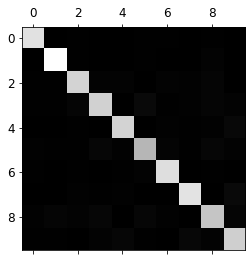

In [55]:
# 이미지로 표현한 confusion_matrix
plt.matshow(conf_mx, cmap=plt.cm.gray) # 빈도가 적으면 검정색
plt.show()

In [56]:
row_sums = conf_mx.sum(axis=1, keepdims=True) # 각 행의 합 구하기
norm_conf_mx = conf_mx / row_sums # (값 / 행의 합) 계산으로 작은 값이 크게 큰 값이 작게 만들기

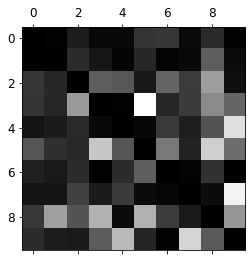

In [57]:
np.fill_diagonal(norm_conf_mx, 0) # fill_diagonal ==> 대각행렬 값 0으로 채우기
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show() # 밝을수록 오분류

#### confusion_matrix 해석 - 행: 실제 클래스, 열: 예측 클래스
1. 8,9열 클래스가 상당히 밝고 행 또한 그러므로 8,9가 다른 숫자들과 많이 혼동됨을 나타냄
2. 클래스1의 열은 매우 어두우므로 대부분 잘 분류됐음을 의미
3. 3과 5의 경우 서로 잘못 분류되는 경우가 많음

#### 해결 방법
1. 더 많은 훈련 데이터 수집
2. 동심원의 수를 세는 새로운 알고리즘 개발과 같은 분류기에 도움이 될 특성 찾기

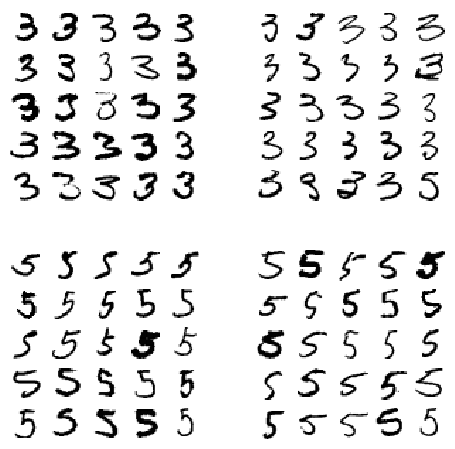

In [58]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] # 3 -> 3
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] # 3 -> 5
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] # 5 -> 3
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] # 5 -> 5

plt.figure(figsize=(8,8)) # 만들어둔 plot_digits 함수 사용
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5) # 1행1열; 3 -> 3
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5) # 1행2열; 3 -> 5
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5) # 2행1열; 5 -> 3
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5) # 2행2열; 5 -> 5
plt.show()

#### 3과 5 오분류 분석
- 선형 분류 모델인 SGDClassifier를 사용 --> 선형 분류기는 클래스 마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중합을 클래스의 점수로 계산했기 떄문(3과 5의 주요 차이는 위와 아래쪽 호를 이어주는 작은 직선의 위치)

#### 해결 방법
- 3과 5의 주요 차이는 이미지의 위치나 회전 방향에 매우 민감하므로 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리

## 3.6 다중 레이블 분류

In [59]:
from sklearn.neighbors import KNeighborsClassifier # KNN은 다중 레이블 분류를 지원하나 다른 모델들도 모두 지원하는 것은 아님

y_train_large = (y_train >= 7) # 7보다 크거나 같은 값인지?
y_train_odd = (y_train % 2 == 1) # 홀수인지?
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [60]:
knn_clf.predict([some_digit]) # 9이므로 두 레이블 모두 맞게 분류

array([[ True,  True]])

In [61]:
# 다중 레이블의 성능평가(f1-score) - 매우 오래걸리므로 생략
#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
#f1_score(y_multilabel, y_train_knn_pred, average="macro") # average='weight'로 설정하면 레이블에 가중치

## 3.7 다중 출력 분류
- 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화(즉, 값을 두 개 이상 가질 수 있음)

In [62]:
# X 훈련, 테스트 데이터에는 노이즈를 더하고, Y 훈련, 테스트 데이터는 원본 X의 데이터 만들어서 노이즈 제거하는 학습을 하는 것
noise = np.random.randint(0, 100, (len(X_train), 784)) # 0~100 사이의 수를 (행의 수, 784) 형태로 만들기
X_train_mod = X_train + noise # 노이즈 추가
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise # 노이즈 추가
y_train_mod = X_train
y_test_mod = X_test

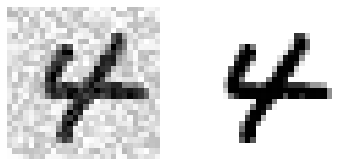

In [63]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

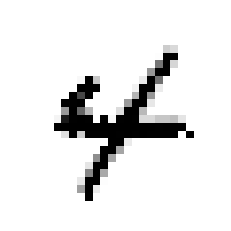

In [64]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

### 추가. 더미(랜덤) 분류기

In [65]:
from sklearn.dummy import DummyClassifier

dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

C:\Users\Yoo\Anaconda3\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


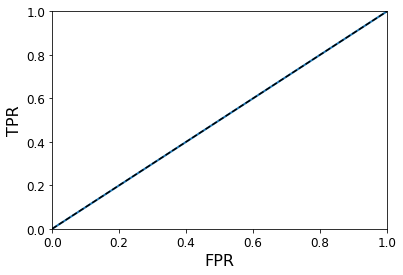

In [66]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)